### **Patrones de Consumo de Agua Potable de Tanques de suminsitro mediante ML y DL**
by: Jorge Torrico

El objetivo de este proyecto es desarrollar una solución basada en datos que permita identificar patrones de consumo y generar modelos predictivos para estimar el consumo futuro de agua potable. Esta solución mejorará la gestión de los recursos hídricos y la planificación de la distribución de agua, lo que conducirá a una mayor eficiencia y sostenibilidad

Se recolecta la información provenientes de monitoreo automatizado de un tanque elevado de suministro de agua potable, que tiene una tasa de alimentación de la fuente hacia el tanque almacenamiento de 9.5 litros por segundo, con una capacidad de almacenamiento de 240 metros cúbicos que suministra agua a 1000 conexiones domiciliarias en una localidad de Bolivia.

**Dataset**
Plataforma embebida compuesta por un electronica de microntrolador y sensor de distancia

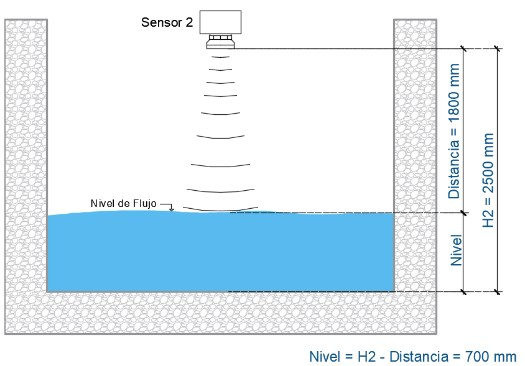

**Preprocesamiento**
Los datos provenientes de la paltaforma embebida son preprocesados para generar los feautures del evento regisrado

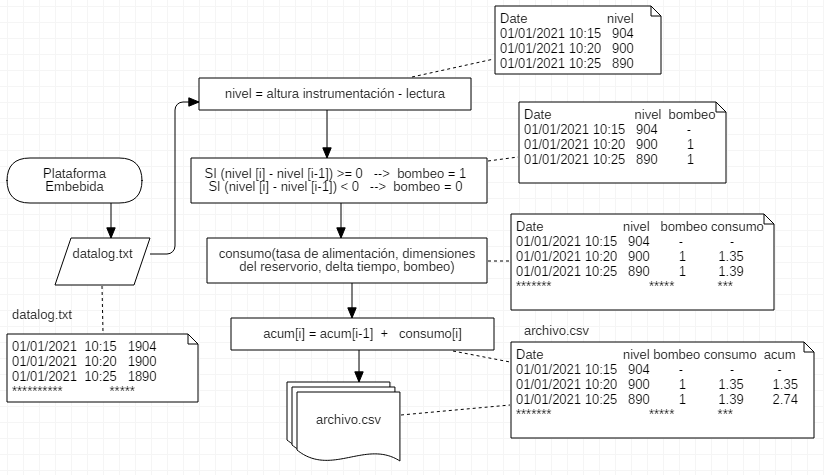

Dimensiones: número de records, atributos/features/características
* 3999 registros
* 5 atributos
* Aproximadamente 14 días de observación, cada día con 288 registros en intervalos de 5 minutos.
* Formato: csv


Atributos:

*   Date: Sello de tiempo en formato MM/DD/AAAA hh:mm.
*   Nivel: Altura de almacenamiento en mm.
*   Bombeo: [0: Sin bombeo] y [1: Con bombeo].
*   Consumo: Consumo de agua cada 5 minutos en m3.
*   Acum: Consumo acumulado cada 5 minutos en m3.



### **Análisis Exploratorio**

In [74]:
#Librerías basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Descomposicion de la Serie de Tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [75]:
# Cambia el nombre del archivo a tu archivo .csv
archivo_csv = '/content/004Y.csv'
# Carga el archivo .csv y selecciona la hoja 'INI' y las columnas 'Date' y 'consumo'
datos = pd.read_csv(archivo_csv, usecols=['Date', 'nivel', 'bombeo', 'consumo', 'acum'])
# Si deseas redondear la columna 'consumo' a 3 decimales, puedes hacerlo aquí
datos['consumo'] = datos['consumo'].round(3)
# Establece la columna 'Date' como índice
datos.set_index('Date', inplace=True)
# Muestra las primeras filas de los datos cargados
datos.head()


,nivel,bombeo,consumo,acum
Date,,,,
07/05/2021 09:40,1746,0,1.000,0.000
07/05/2021 09:45,1730,0,1.000,1.000
07/05/2021 09:50,1714,0,1.106,2.106
07/05/2021 09:55,1701,0,1.032,3.138
07/05/2021 10:00,1688,0,1.008,4.145


In [76]:
fecha_inicio = pd.DataFrame(datos.index)['Date'].min()
fecha_fin = pd.DataFrame(datos.index)['Date'].max()
num_dias = pd.DataFrame(datos.index)['Date'].nunique()
print('Fecha inicio del histórico:', fecha_inicio)
print('Fecha fin del histórico:', fecha_fin)
print('Número total de registros:', num_dias)

Fecha inicio del histórico: 07/05/2021 09:40
Fecha fin del histórico: 07/19/2021 06:50
Número total de registros: 3999


In [77]:
# Mostrar las estadísticas descriptivas
descripcion = datos.describe()
print(descripcion)

             nivel       bombeo      consumo         acum
count  3999.000000  3999.000000  3999.000000  3999.000000
mean   1873.533133     0.271068     0.742456  1538.024369
std     149.930342     0.444567     0.305575   863.753891
min    1583.000000     0.000000     0.123000     0.000000
25%    1744.000000     0.000000     0.467000   803.745000
50%    1876.000000     0.000000     0.762000  1552.954000
75%    2008.000000     1.000000     1.008000  2294.708500
max    2123.000000     1.000000     1.388000  2968.045000


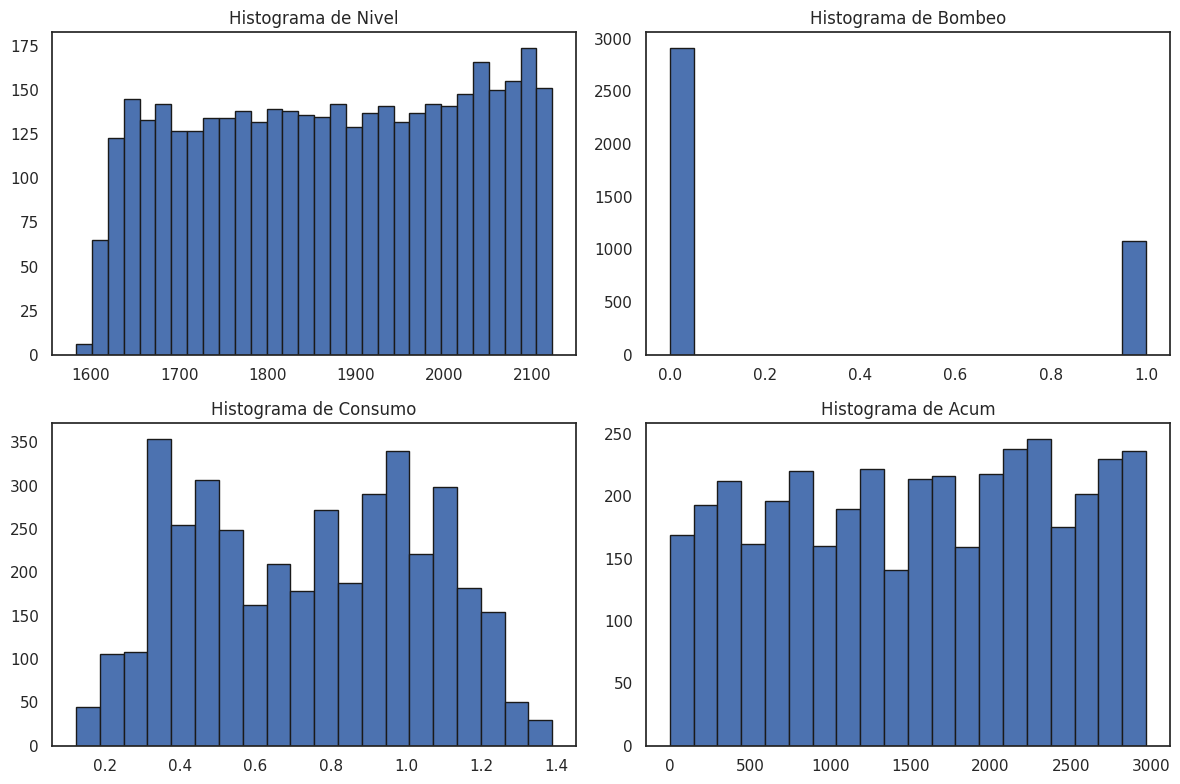

In [78]:
# Crear una figura con cuatro subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Histograma de 'nivel'
axs[0, 0].hist(datos['nivel'], bins=30, edgecolor='k')
axs[0, 0].set_title('Histograma de Nivel')

# Histograma de 'bombeo'
axs[0, 1].hist(datos['bombeo'], bins=20, edgecolor='k')
axs[0, 1].set_title('Histograma de Bombeo')

# Histograma de 'consumo'
axs[1, 0].hist(datos['consumo'], bins=20, edgecolor='k')
axs[1, 0].set_title('Histograma de Consumo')

# Histograma de 'acum'
axs[1, 1].hist(datos['acum'], bins=20, edgecolor='k')
axs[1, 1].set_title('Histograma de Acum')

# Ajustar los espacios entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


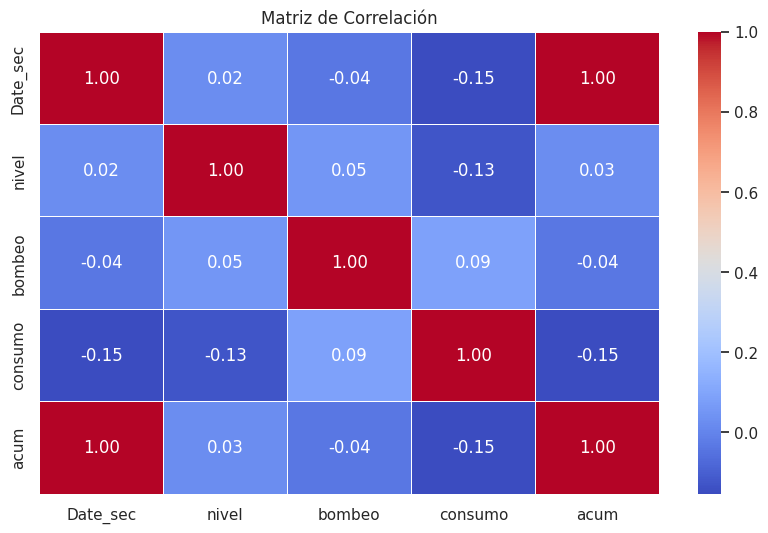

In [79]:
# Matriz Correlación
datos_c = pd.read_csv(archivo_csv, usecols=['Date', 'nivel', 'bombeo', 'consumo', 'acum'])

# Convertir la columna 'Date' a formato de tiempo en el DataFrame 'datos_c'
datos_c['Date'] = pd.to_datetime(datos_c['Date'])

# Calcular el número de segundos desde una fecha de referencia (por ejemplo, 1970-01-01)
fecha_referencia = pd.Timestamp('1970-01-01')
datos_c['Date_sec'] = (datos_c['Date'] - fecha_referencia).dt.total_seconds()

# Calcular la matriz de correlación
matriz_correlacion = datos_c[['Date_sec', 'nivel', 'bombeo', 'consumo', 'acum']].corr()

# Crear un mapa de calor
sns.set(style="white")  # Estilo del gráfico
plt.figure(figsize=(10, 6))  # Tamaño de la figura
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


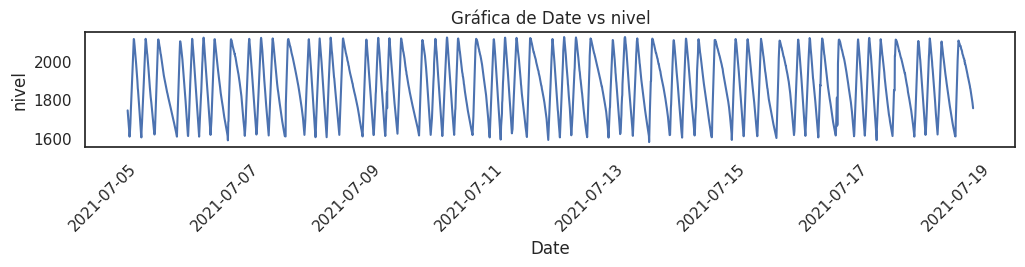

In [80]:
# Visualiza las variaciones de nivel
import pandas as pd
import matplotlib.pyplot as plt

# Cambia el nombre del archivo a tu archivo .csv
archivo_csv = '/content/004Y.csv'

# Carga el archivo .csv
data = pd.read_csv(archivo_csv)

# Convierte la columna 'Date' en formato datetime si no lo está ya
data['Date'] = pd.to_datetime(data['Date'])

# Crea la figura y el gráfico
fig = plt.figure(figsize=(12, 1.5))  # Ancho: 12 pulgadas, Alto: 1.5 pulgadas
plt.plot(data['Date'], data['nivel'])
plt.xlabel('Date')
plt.ylabel('nivel')
plt.title('Gráfica de Date vs nivel')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor claridad

plt.show()


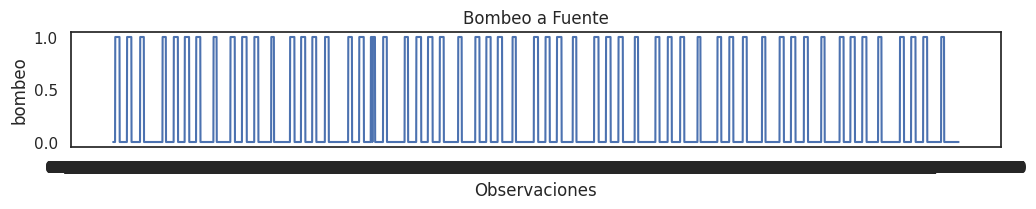

In [81]:
# Visualiza la serie de tiempo
plt.figure(figsize=(12, 1.5))
plt.plot(datos.index, datos['bombeo'])
plt.xlabel('Observaciones')
plt.ylabel('bombeo')
plt.title('Bombeo a Fuente')
plt.show()

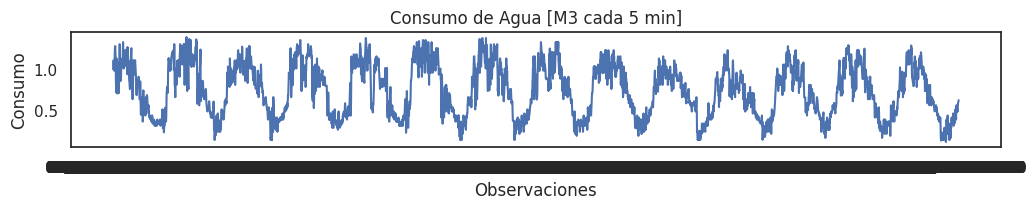

In [82]:
# Visualiza la serie de tiempo
plt.figure(figsize=(12, 1.5))
plt.plot(datos.index, datos['consumo'])
plt.xlabel('Observaciones')
plt.ylabel('Consumo')
plt.title('Consumo de Agua [M3 cada 5 min]')
plt.show()

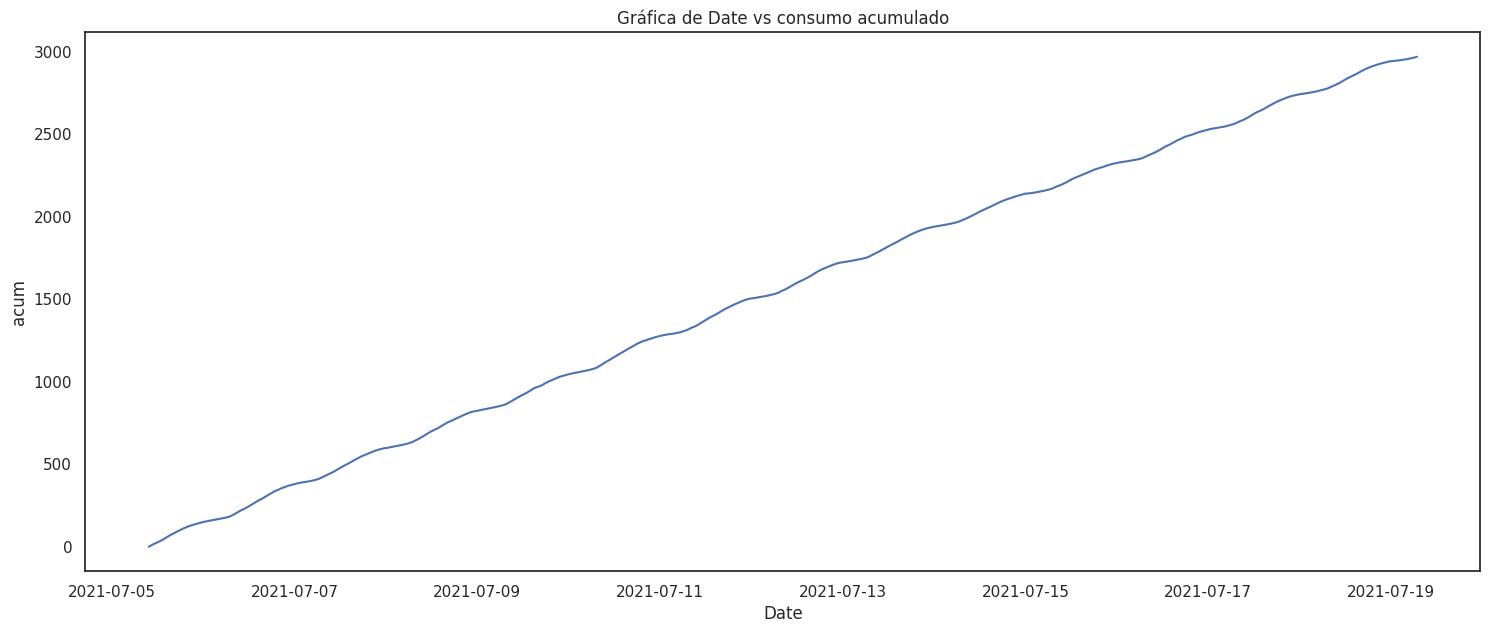

In [83]:
# Muesra el consumo acumulado
fig = plt.figure(figsize=(18, 7))
plt.plot(data['Date'], data['acum'])
plt.xlabel('Date')
plt.ylabel('acum')
plt.title('Gráfica de Date vs consumo acumulado')
plt.show()

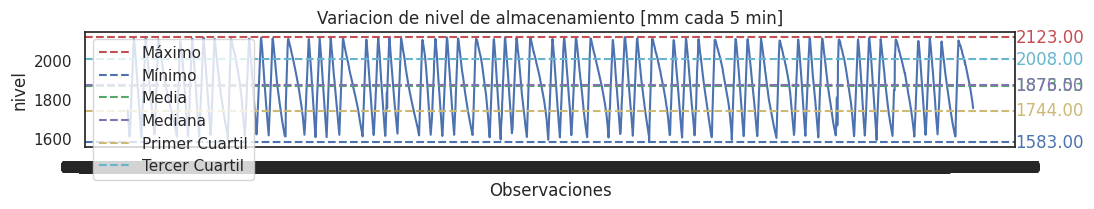

In [84]:
# Visualiza la serie de tiempo
plt.figure(figsize=(12, 1.5))
plt.plot(datos.index, datos['nivel'])
plt.xlabel('Observaciones')
plt.ylabel('nivel')
plt.title('Variacion de nivel de almacenamiento [mm cada 5 min]')

# Estadísticas descriptivas
maximum = datos['nivel'].max()
minimum = datos['nivel'].min()
mean = datos['nivel'].mean()
median = datos['nivel'].median()
q1 = np.percentile(datos['nivel'], 25)
q3 = np.percentile(datos['nivel'], 75)

# Agregar líneas para los valores estadísticos
plt.axhline(maximum, color='r', linestyle='--', label='Máximo')
plt.axhline(minimum, color='b', linestyle='--', label='Mínimo')
plt.axhline(mean, color='g', linestyle='--', label='Media')
plt.axhline(median, color='m', linestyle='--', label='Mediana')
plt.axhline(q1, color='y', linestyle='--', label='Primer Cuartil')
plt.axhline(q3, color='c', linestyle='--', label='Tercer Cuartil')

# Agregar valores numéricos
plt.text(plt.xlim()[1], maximum, f'{maximum:.2f}', va='center', ha='left', color='r')
plt.text(plt.xlim()[1], minimum, f'{minimum:.2f}', va='center', ha='left', color='b')
plt.text(plt.xlim()[1], mean, f'{mean:.2f}', va='center', ha='left', color='g')
plt.text(plt.xlim()[1], median, f'{median:.2f}', va='center', ha='left', color='m')
plt.text(plt.xlim()[1], q1, f'{q1:.2f}', va='center', ha='left', color='y')
plt.text(plt.xlim()[1], q3, f'{q3:.2f}', va='center', ha='left', color='c')

plt.legend()
plt.show()

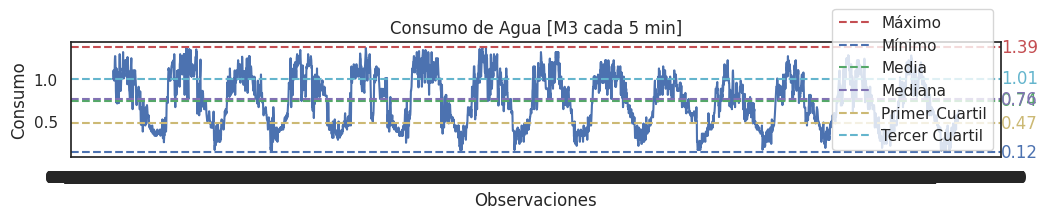

In [85]:
# Visualiza la serie de tiempo
plt.figure(figsize=(12, 1.5))
plt.plot(datos.index, datos['consumo'])
plt.xlabel('Observaciones')
plt.ylabel('Consumo')
plt.title('Consumo de Agua [M3 cada 5 min]')

# Estadísticas descriptivas
maximum = datos['consumo'].max()
minimum = datos['consumo'].min()
mean = datos['consumo'].mean()
median = datos['consumo'].median()
q1 = np.percentile(datos['consumo'], 25)
q3 = np.percentile(datos['consumo'], 75)

# Agregar líneas para los valores estadísticos
plt.axhline(maximum, color='r', linestyle='--', label='Máximo')
plt.axhline(minimum, color='b', linestyle='--', label='Mínimo')
plt.axhline(mean, color='g', linestyle='--', label='Media')
plt.axhline(median, color='m', linestyle='--', label='Mediana')
plt.axhline(q1, color='y', linestyle='--', label='Primer Cuartil')
plt.axhline(q3, color='c', linestyle='--', label='Tercer Cuartil')

# Agregar valores numéricos
plt.text(plt.xlim()[1], maximum, f'{maximum:.2f}', va='center', ha='left', color='r')
plt.text(plt.xlim()[1], minimum, f'{minimum:.2f}', va='center', ha='left', color='b')
plt.text(plt.xlim()[1], mean, f'{mean:.2f}', va='center', ha='left', color='g')
plt.text(plt.xlim()[1], median, f'{median:.2f}', va='center', ha='left', color='m')
plt.text(plt.xlim()[1], q1, f'{q1:.2f}', va='center', ha='left', color='y')
plt.text(plt.xlim()[1], q3, f'{q3:.2f}', va='center', ha='left', color='c')

plt.legend()
plt.show()


### **Análisis de Patrones de Almacenamiento y Consumo**

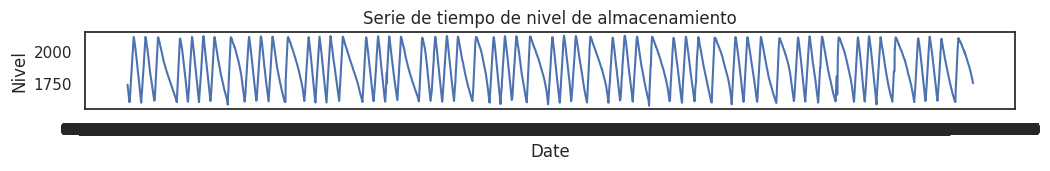

<Figure size 1000x300 with 0 Axes>

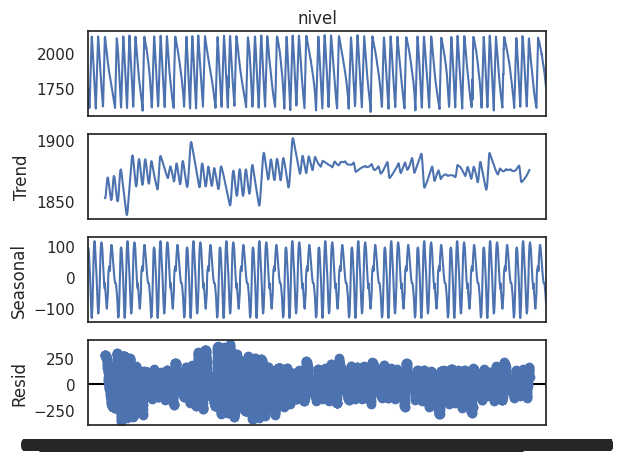

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Visualizar la serie de tiempo
plt.figure(figsize=(12, 1))
sns.lineplot(data=datos, x=datos.index, y='nivel')
plt.xlabel('Date')
plt.ylabel('Nivel')
plt.title('Serie de tiempo de nivel de almacenamiento')
plt.show()

# Descomposición de la serie de tiempo en componentes (tendencia, estacionalidad, residuo)
decomposition = seasonal_decompose(datos['nivel'], model='additive', period=288)

# Graficar los componentes de la descomposición
plt.figure(figsize=(10, 3))
decomposition.plot()
plt.show()

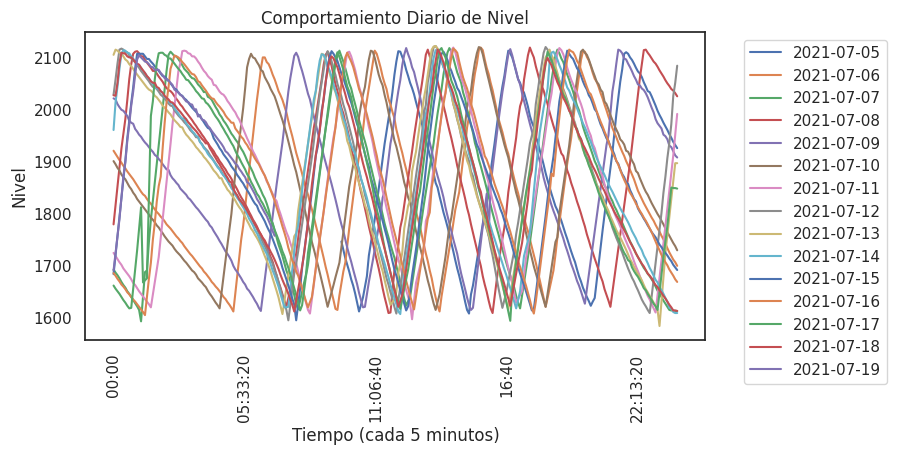

In [87]:
# Comportamiento diario de nivel
datos = pd.read_csv(archivo_csv, usecols=['Date', 'nivel', 'bombeo', 'consumo', 'acum'])

# Convertir la columna 'Date' a formato de tiempo
datos['Date'] = pd.to_datetime(datos['Date'])

# Agrupar los datos por la columna 'Date' (que contiene información de fecha)
datos_diarios = datos.groupby(datos['Date'].dt.date)

# Graficar el comportamiento diario de 'nivel'
plt.figure(figsize=(8, 4))
for fecha, grupo in datos_diarios:
    plt.plot(grupo['Date'].dt.time, grupo['nivel'], label=str(fecha))

plt.xlabel('Tiempo (cada 5 minutos)')
plt.ylabel('Nivel')
plt.title('Comportamiento Diario de Nivel')
plt.xticks(rotation=90)

# Mover la leyenda fuera del gráfico principal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [88]:
# Calcular el total de observaciones en la columna 'bombeo'
total_observaciones = len(datos)

# Contar los valores de 0 y 1 en la columna 'bombeo' por separado
conteo_bombeo_0 = (datos['bombeo'] == 0).sum()
conteo_bombeo_1 = (datos['bombeo'] == 1).sum()

# Multiplicar por 5 y expresar en minutos
minutos_0 = conteo_bombeo_0 * 5
minutos_1 = conteo_bombeo_1 * 5

# Calcular el porcentaje de conteo_bombeo_0 y conteo_bombeo_1 en relación al total
porcentaje_bombeo_0 = round((conteo_bombeo_0 / total_observaciones) * 100, 2)
porcentaje_bombeo_1 = round((conteo_bombeo_1 / total_observaciones) * 100, 2)

# Convertir minutos en horas y minutos
horas_0, minutos_restantes_0 = divmod(minutos_0, 60)
horas_1, minutos_restantes_1 = divmod(minutos_1, 60)

# Mostrar los resultados
print("Tiempo de servicio sin bombeo igual a 0:", horas_0, "horas", minutos_restantes_0, "minutos")
print("Porcentaje de sin bombeo igual a 0:", porcentaje_bombeo_0, "%")
print("Tiempo de servicio on bombeo igual a 1:", horas_1, "horas", minutos_restantes_1, "minutos")
print("Porcentaje de bombeo igual a 1:", porcentaje_bombeo_1, "%")

Tiempo de servicio sin bombeo igual a 0: 242 horas 55 minutos
Porcentaje de sin bombeo igual a 0: 72.89 %
Tiempo de servicio on bombeo igual a 1: 90 horas 20 minutos
Porcentaje de bombeo igual a 1: 27.11 %


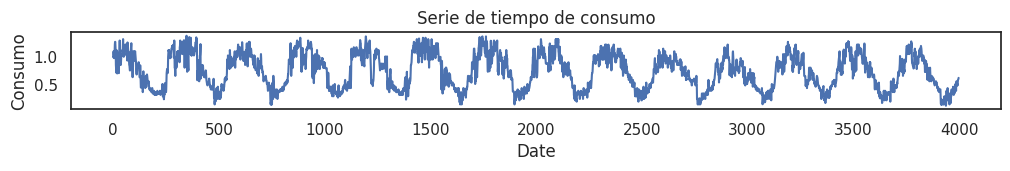

<Figure size 1000x300 with 0 Axes>

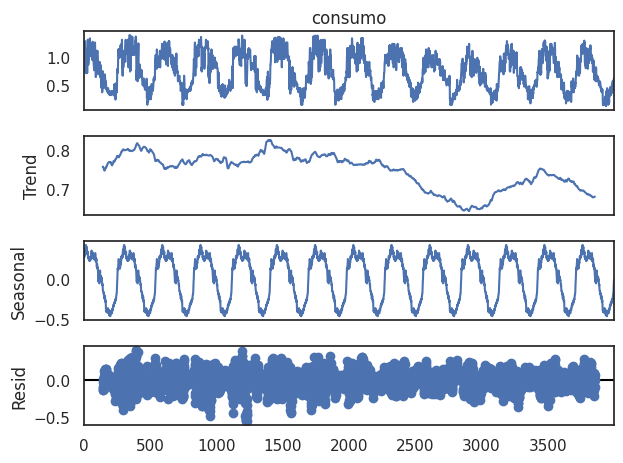

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Visualizar la serie de tiempo
plt.figure(figsize=(12, 1))
sns.lineplot(data=datos, x=datos.index, y='consumo')
plt.xlabel('Date')
plt.ylabel('Consumo')
plt.title('Serie de tiempo de consumo')
plt.show()

# Descomposición de la serie de tiempo en componentes (tendencia, estacionalidad, residuo)
decomposition = seasonal_decompose(datos['consumo'], model='additive', period=288)

# Graficar los componentes de la descomposición
plt.figure(figsize=(10, 3))
decomposition.plot()
plt.show()


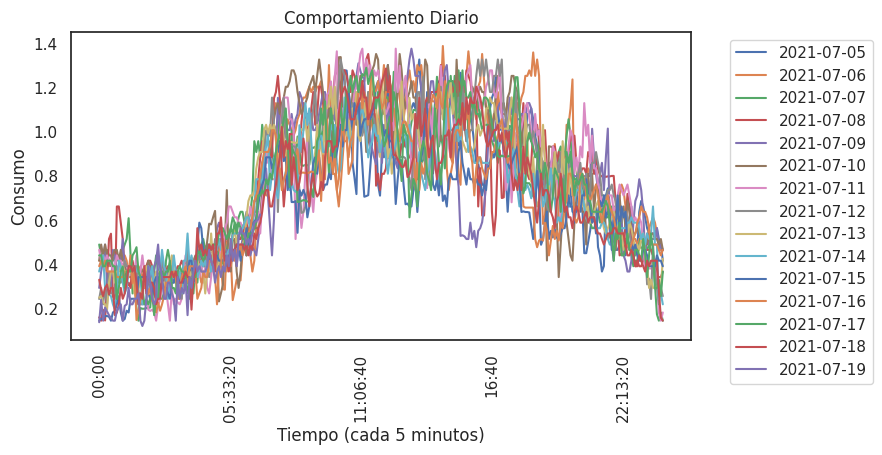

In [90]:
# Comportamiento Diario de Consumo
datos = pd.read_csv(archivo_csv, usecols=['Date', 'nivel', 'bombeo', 'consumo', 'acum'])

# Convertir la columna 'Date' a formato de tiempo
datos['Date'] = pd.to_datetime(datos['Date'])

# Agrupar los datos por la columna 'Date' (que contiene información de fecha)
datos_diarios = datos.groupby(datos['Date'].dt.date)

# Graficar el comportamiento diario de todos los datos
plt.figure(figsize=(8, 4))
for fecha, grupo in datos_diarios:
    plt.plot(grupo['Date'].dt.time, grupo['consumo'], label=str(fecha))

plt.xlabel('Tiempo (cada 5 minutos)')
plt.ylabel('Consumo')
plt.title('Comportamiento Diario')
plt.xticks(rotation=90)

# Mover la leyenda fuera del gráfico principal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [91]:
# Suponiendo que ya has cargado los datos desde el archivo CSV
datos = pd.read_csv(archivo_csv, usecols=['Date', 'nivel', 'bombeo', 'consumo', 'acum'])

# Convertir la columna 'Date' a formato de tiempo
datos['Date'] = pd.to_datetime(datos['Date'])

# Agrupar los datos por día y calcular la suma total de consumo para cada día
consumo_diario = datos.groupby(datos['Date'].dt.date)['consumo'].sum().reset_index()

# Renombrar la columna de fecha y consumo
consumo_diario.columns = ['Fecha', 'Consumo Total']
consumo_diario = consumo_diario.iloc[1:-1]

# Mostrar el DataFrame resultante
print(consumo_diario)

# Estadisticas de consumo diario
estadisticas_consumo = consumo_diario['Consumo Total'].describe()
print(estadisticas_consumo)

# Estadisticas de consumo diario por personsa
consumo_diario['Consumo Persona'] = consumo_diario['Consumo Total'] / 5000
print(consumo_diario)

estadisticas_consumo = consumo_diario['Consumo Persona'].describe()
print(estadisticas_consumo)


         Fecha  Consumo Total
1   2021-07-06        230.207
2   2021-07-07        217.807
3   2021-07-08        226.298
4   2021-07-09        220.622
5   2021-07-10        232.133
6   2021-07-11        226.958
7   2021-07-12        219.436
8   2021-07-13        215.376
9   2021-07-14        200.083
10  2021-07-15        185.809
11  2021-07-16        202.725
12  2021-07-17        213.568
13  2021-07-18        200.056
count     13.000000
mean     214.698308
std       13.857111
min      185.809000
25%      202.725000
50%      217.807000
75%      226.298000
max      232.133000
Name: Consumo Total, dtype: float64
         Fecha  Consumo Total  Consumo Persona
1   2021-07-06        230.207         0.046041
2   2021-07-07        217.807         0.043561
3   2021-07-08        226.298         0.045260
4   2021-07-09        220.622         0.044124
5   2021-07-10        232.133         0.046427
6   2021-07-11        226.958         0.045392
7   2021-07-12        219.436         0.043887
8   2021

### **Holt-Winters**

In [94]:
#Librerías basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Descomposicion de la Serie de Tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [95]:
# Import packages
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Read in the data
datos = pd.read_csv('/content/004Y.csv', usecols=['Date', 'consumo'])
datos['consumo'] = datos['consumo'].round(3)
datos['Date'] = pd.to_datetime(datos['Date'])

# Split train and test
train = datos.iloc[:3199]
test = datos.iloc[3199:3999]  # 1152 , 1440 , 1728

In [96]:
def plot_func(forecast1: list[float],
              title: str,
              save_path: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['consumo'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['consumo'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecast1, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Observaciones',
                      yaxis_title='Volumen Consumido M3 cad 5 min')
    return fig.show()

# Fit Holt's model and get forecasts
model_holt = Holt(train['consumo'], damped_trend=True).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(test))

# Fit Holt Winters model and get forecasts
model_holt_winters = ExponentialSmoothing(train['consumo'], trend='add',
                                          seasonal='add', seasonal_periods=288)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(test))

# Plot the forecasts
plot_func(forecasts_holt_winters, "Holt-Winters", "")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [97]:
# Obtener los valores de los datos de prueba
datos_prueba = np.array(test['consumo'])
# Calcular el RMSE y MAE para el método
rmse_holt_winters = np.sqrt(mean_squared_error(datos_prueba, forecasts_holt_winters))
mae_holt_winters = mean_absolute_error(datos_prueba, forecasts_holt_winters)


# Calcular R^2 utilizando RMSE y MAE
y_mean = np.mean(datos_prueba)
sse = np.sum((datos_prueba - forecasts_holt_winters) ** 2)
sst = np.sum((datos_prueba - y_mean) ** 2)
r2_holt_winters = 1 - (sse / sst)

print("RMSE Holt-Winters:", rmse_holt_winters)
print("MAE Holt-Winters:", mae_holt_winters)
print("R^2 Holt-Winters:", r2_holt_winters)

RMSE Holt-Winters: 0.23165567446015747
MAE Holt-Winters: 0.20195501927806667
R^2 Holt-Winters: 0.39475723186555445


OPTIMIZACIÓN

In [98]:
datos = pd.read_csv('/content/004Y.csv', usecols=['Date', 'consumo'])
datos['consumo'] = datos['consumo'].round(3)
datos['Date'] = pd.to_datetime(datos['Date'])
# Particion entrenamiento y test
train = datos.iloc[:3199]
test = datos.iloc[3199:3999] # 1152 , 1440 , 1728

# Ajuste modelo Holt Winters y pronóstico
model_holt_winters = ExponentialSmoothing(train['consumo'], trend='add', damped_trend=True,
                                          seasonal='add', seasonal_periods=288)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(test))

# Mostrar pronóstico
plot_func(forecasts_holt_winters, "Holt-Winters", "")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [99]:
# Obtener los valores de los datos de prueba
datos_prueba = np.array(test['consumo'])

# Calcular el RMSE y MAE para el método
rmse_holt_winters = np.sqrt(mean_squared_error(datos_prueba, forecasts_holt_winters))
mae_holt_winters = mean_absolute_error(datos_prueba, forecasts_holt_winters)

# Calcular R^2 utilizando RMSE y MAE
y_mean = np.mean(datos_prueba)
sse = np.sum((datos_prueba - forecasts_holt_winters) ** 2)
sst = np.sum((datos_prueba - y_mean) ** 2)
r2_holt_winters = 1 - (sse / sst)

print("RMSE Holt-Winters:", rmse_holt_winters)
print("MAE Holt-Winters:", mae_holt_winters)
print("R^2 Holt-Winters:", r2_holt_winters)

RMSE Holt-Winters: 0.21413631072579062
MAE Holt-Winters: 0.1841756283059398
R^2 Holt-Winters: 0.48284068031685456


### **ARIMA**


In [100]:
!pip install pmdarima

In [101]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima

datos = pd.read_csv('/content/004Y.csv', usecols=['Date', 'consumo'])
datos['Date'] = pd.to_datetime(datos['Date'])
datos = datos.set_index('Date')
#datos.head()

datos_1h = datos.resample('1H').sum()
datos_1h

,consumo
Date,
2021-07-05 09:00:00,4.138
2021-07-05 10:00:00,12.571
2021-07-05 11:00:00,10.437
2021-07-05 12:00:00,11.574
2021-07-05 13:00:00,13.516
...,...
2021-07-19 02:00:00,3.661
2021-07-19 03:00:00,3.280
2021-07-19 04:00:00,4.646


In [102]:
# Partición entrenamiento y test
train = datos_1h.iloc[:267]
test = datos_1h.iloc[267:334]  # 207 , 255 , 292

In [103]:
# Identificador de los mejores parametro con AutoArima
model = auto_arima(train, seasonal=True, m=24, trace=True, stepwise=True, trend='n',
                   start_p=1, star_q=2, max_p=1, max_q=2, d=1,
                   start_P=2, star_Q=0, max_P=2, max_Q=1, D=1)

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(2,1,1)[24]             : AIC=817.752, Time=25.61 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=985.301, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=952.406, Time=0.89 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=840.459, Time=3.53 sec
 ARIMA(1,1,2)(1,1,1)[24]             : AIC=inf, Time=14.32 sec
 ARIMA(1,1,2)(2,1,0)[24]             : AIC=835.702, Time=19.03 sec
 ARIMA(1,1,2)(1,1,0)[24]             : AIC=863.168, Time=5.34 sec
 ARIMA(0,1,2)(2,1,1)[24]             : AIC=815.755, Time=17.10 sec
 ARIMA(0,1,2)(1,1,1)[24]             : AIC=inf, Time=4.72 sec
 ARIMA(0,1,2)(2,1,0)[24]             : AIC=833.713, Time=4.64 sec
 ARIMA(0,1,2)(1,1,0)[24]             : AIC=862.312, Time=2.06 sec
 ARIMA(0,1,1)(2,1,1)[24]             : AIC=833.488, Time=7.57 sec
 ARIMA(1,1,1)(2,1,1)[24]             : AIC=820.216, Time=16.63 sec
 ARIMA(0,1,2)(2,1,1)[24] intercept   : AIC=815.755, Time=23.00 sec

Best model:  ARIMA(0,1,2)(2,1,1)[2

In [104]:
# Ajustar el modelo ARIMA con los parámetros determinados por AutoARIMA
model.fit(train)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 1, 1, 24),
      suppress_warnings=True, trend='n', with_intercept=False)

In [105]:
# Realizar predicciones en el conjunto de prueba
predictions = model.predict(n_periods=len(test))

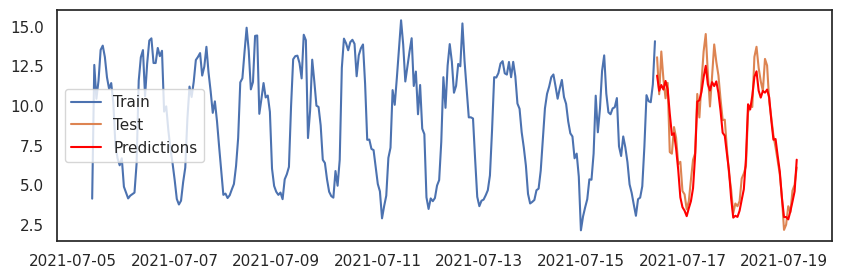

In [106]:
# Visualizar los resultados
plt.figure(figsize=(10, 3))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.show()

In [107]:
# Calcular el error RMSE 2

mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
r2 = r2_score(test, predictions)

print("RMSE:", rmse)
print("MAE:", mae)
print("R^2:", r2)

RMSE: 1.0426074989401457
MAE: 0.8440763559216518
R^2: 0.9083131296787761


### **Red neuronal con LSTM**


Epoch 1/100
97/97 [==============================] - 48s 324ms/step - loss: 0.0226
Epoch 2/100
97/97 [==============================] - 18s 186ms/step - loss: 0.0089
Epoch 3/100
97/97 [==============================] - 23s 234ms/step - loss: 0.0082
Epoch 4/100
97/97 [==============================] - 11s 114ms/step - loss: 0.0076
Epoch 5/100
97/97 [==============================] - 13s 136ms/step - loss: 0.0070
Epoch 6/100
97/97 [==============================] - 12s 121ms/step - loss: 0.0064
Epoch 7/100
97/97 [==============================] - 13s 136ms/step - loss: 0.0059
Epoch 8/100
97/97 [==============================] - 13s 138ms/step - loss: 0.0055
Epoch 9/100
97/97 [==============================] - 12s 126ms/step - loss: 0.0051
Epoch 10/100
97/97 [==============================] - 12s 125ms/step - loss: 0.0049
Epoch 11/100
97/97 [==============================] - 12s 124ms/step - loss: 0.0051
Epoch 12/100
97/97 [==============================] - 12s 126ms/step - loss: 0.0048
E

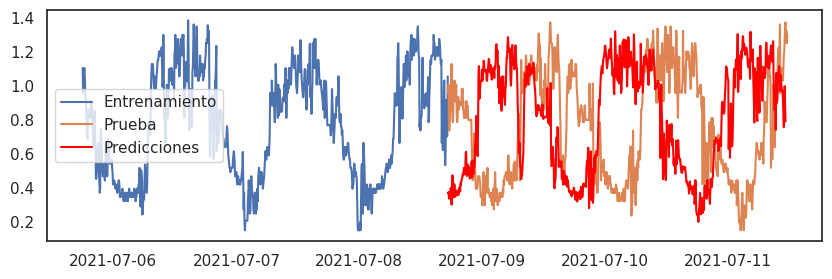

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

datos = pd.read_csv('/content/004Y.csv', usecols=['Date', 'consumo'])

datos['Date'] = pd.to_datetime(datos['Date'])
datos = datos.set_index('Date')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(datos)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
train_data = scaled_data[:3199]
test_data = scaled_data[3199:3999]  #  1244, 1531, 1751


# Función para crear secuencias de datos y etiquetas
def create_sequences(datos, seq_length):
    sequences = []
    labels = []
    for i in range(len(datos) - seq_length):
        sequences.append(datos[i:i+seq_length])
        labels.append(datos[i+seq_length])
    return np.array(sequences), np.array(labels)

# Definir la longitud de la secuencia
sequence_length = 100

# Crear las secuencias y etiquetas correspondientes para los conjuntos de entrenamiento y prueba
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Construir el modelo de red neuronal con LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, 1), return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)  # 50, 100  OPTIMIZADOR

# Realizar predicciones en todo el conjunto de datos
all_data = scaled_data.reshape(-1, 1)
X_all, y_all = create_sequences(all_data, sequence_length)
predictions = model.predict(X_all)

# Desnormalizar las predicciones y etiquetas
predictions = scaler.inverse_transform(predictions)
y_all = scaler.inverse_transform(y_all)

#******

# Realizar predicciones en el conjunto de datos de prueba
test_predictions = model.predict(X_test)

# Desnormalizar las predicciones y las etiquetas
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Mostrar las métricas
print("RMSE:", rmse)
print("MAE:", mae)
print("R^2:", r2)
#*****


# Desplegar los resultados
plt.figure(figsize=(10, 3))
plt.plot(datos.index[sequence_length:956], datos.values[sequence_length:956], label='Entrenamiento')
plt.plot(datos.index[956:1751], datos.values[956:1751], label='Prueba')
plt.plot(datos.index[956:1747], predictions[956:1747], label='Predicciones', color='red')
plt.legend()
plt.show()

Epoch 1/100
97/97 [==============================] - 18s 137ms/step - loss: 0.0244
Epoch 2/100
97/97 [==============================] - 12s 126ms/step - loss: 0.0098
Epoch 3/100
97/97 [==============================] - 11s 118ms/step - loss: 0.0089
Epoch 4/100
97/97 [==============================] - 12s 120ms/step - loss: 0.0081
Epoch 5/100
97/97 [==============================] - 13s 129ms/step - loss: 0.0073
Epoch 6/100
97/97 [==============================] - 13s 129ms/step - loss: 0.0072
Epoch 7/100
97/97 [==============================] - 12s 127ms/step - loss: 0.0063
Epoch 8/100
97/97 [==============================] - 12s 122ms/step - loss: 0.0056
Epoch 9/100
97/97 [==============================] - 12s 125ms/step - loss: 0.0054
Epoch 10/100
97/97 [==============================] - 12s 126ms/step - loss: 0.0049
Epoch 11/100
97/97 [==============================] - 12s 124ms/step - loss: 0.0051
Epoch 12/100
97/97 [==============================] - 12s 128ms/step - loss: 0.0048
E

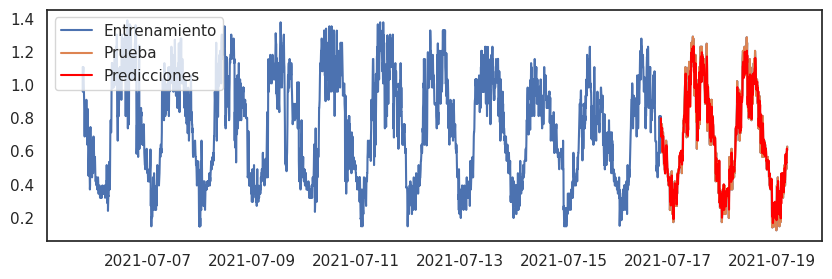

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

datos = pd.read_csv('/content/004Y.csv', usecols=['Date', 'consumo'])

datos['Date'] = pd.to_datetime(datos['Date'])
datos = datos.set_index('Date')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(datos)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
train_data = scaled_data[:3199]
test_data = scaled_data[3199:]  # Asegúrate de ajustar esta división según tus datos

# Definir la longitud de la secuencia
sequence_length = 100  # Ajusta la longitud de la secuencia según tus necesidades

# Crear las secuencias y etiquetas correspondientes para los conjuntos de entrenamiento y prueba
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Construir el modelo de red neuronal con LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, 1), return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)  # Ajusta los hiperparámetros según sea necesario

# Realizar predicciones en todo el conjunto de datos
all_data = scaled_data.reshape(-1, 1)
X_all, y_all = create_sequences(all_data, sequence_length)
predictions = model.predict(X_all)

# Desnormalizar las predicciones y etiquetas
predictions = scaler.inverse_transform(predictions)
y_all = scaler.inverse_transform(y_all)

# Desplegar los resultados
plt.figure(figsize=(10, 3))
plt.plot(datos.index[sequence_length:], datos.values[sequence_length:], label='Entrenamiento')
plt.plot(datos.index[3199 + sequence_length:], datos.values[3199 + sequence_length:], label='Prueba')  # Ajusta los índices según tus datos
plt.plot(datos.index[3199 + sequence_length:], predictions[3199:], label='Predicciones', color='red')  # Ajusta los índices según tus datos
plt.legend()
plt.show()


In [110]:
# Realizar predicciones en el conjunto de datos de prueba
test_predictions = model.predict(X_test)

# Desnormalizar las predicciones y las etiquetas
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Mostrar las métricas
print("RMSE:", rmse)
print("MAE:", mae)
print("R^2:", r2)

22/22 [==============================] - 1s 31ms/step
RMSE: 0.0688468180523683
MAE: 0.05171253095201083
R^2: 0.9475593644133015


### **XGBOOST**

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores parámetros: {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.7}
RMSE: 0.07322214678461123
MAE: 0.055249342254698276
R^2: 0.9395315775251769


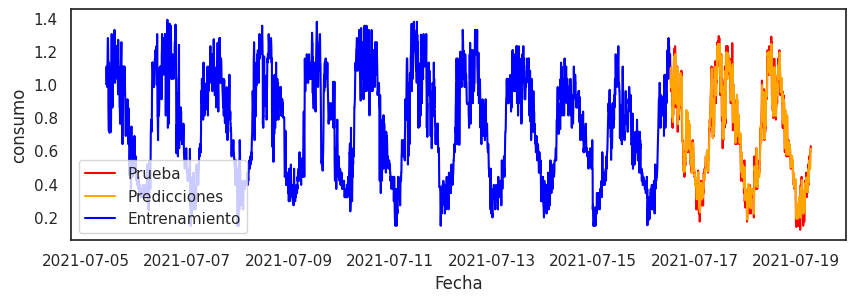

In [111]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Leer los datos
datos = pd.read_csv('/content/004Y.csv', usecols=['Date', 'consumo'])
datos['consumo'] = datos['consumo'].round(3)
datos['Date'] = pd.to_datetime(datos['Date'])

# Crear características con retraso
lags = [1, 2, 3]  # Número de características con retraso a crear
for lag in lags:
    datos['consumo_lag_{}'.format(lag)] = datos['consumo'].shift(lag)

# Dividir en entrenamiento y prueba
train = datos.iloc[:3199]
test = datos.iloc[3199:3999].dropna()   # 1243 , 1531 , 1751

# Convertir los datos a arrays
x_train = train.drop(['Date', 'consumo'], axis=1).values
y_train = train['consumo'].values
x_test = test.drop(['Date', 'consumo'], axis=1).values
y_test = test['consumo'].values

# Crear DMatrix para XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Establecer los parámetros iniciales de XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Realizar la búsqueda de hiperparámetros mediante validación cruzada
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(**params),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1)

# Ajustar el modelo de búsqueda de hiperparámetros
grid_search.fit(x_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Realizar predicciones en los datos de prueba con el mejor modelo
y_pred = best_model.predict(x_test)

# Calcular las métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mejores parámetros:', best_params)
print('RMSE:', rmse)
print('MAE:', mae)
print('R^2:', r2)

# Graficar los valores reales, valores predichos y datos de entrenamiento
plt.figure(figsize=(10, 3))
plt.plot(test['Date'], y_test, color='red', label='Prueba')
plt.plot(test['Date'], y_pred, color='orange', label='Predicciones')
plt.plot(train['Date'], train['consumo'], color='blue', label='Entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('consumo')
plt.legend()
plt.show()

OPTIMIZADOR

RMSE: 0.07289751132948752
MAE: 0.055066288725137705
R^2: 0.940066570797004


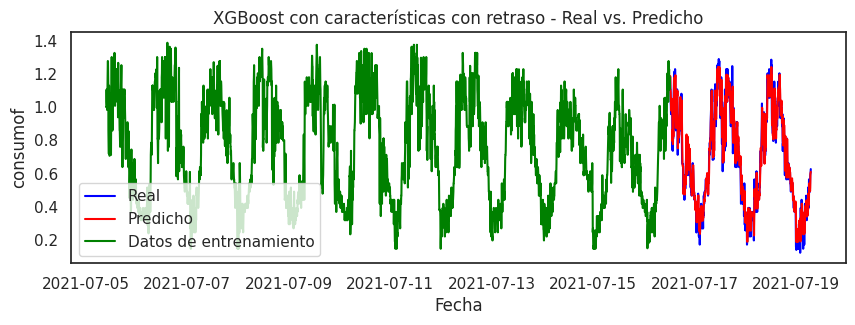

In [112]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Leer los datos
datos = pd.read_csv('/content/004Y.csv', usecols=['Date', 'consumo'])

datos['consumo'] = datos['consumo'].round(3)
datos['Date'] = pd.to_datetime(datos['Date'])

# Crear características con retraso (lags)
lags = [1, 2, 3]  # Número de características con retraso a crear
for lag in lags:
    datos['consumof_lag_{}'.format(lag)] = datos['consumo'].shift(lag)

# Dividir en entrenamiento y prueba
train = datos.iloc[:3199]
test = datos.iloc[3199:3999].dropna()   # 1243 , 1531 , 1751

# Convertir los datos a arrays
x_train = train.drop(['Date', 'consumo'], axis=1).values
y_train = train['consumo'].values
x_test = test.drop(['Date', 'consumo'], axis=1).values
y_test = test['consumo'].values

# Crear DMatrix para XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Establecer los parámetros de XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Entrenar el modelo XGBoost
model = xgb.train(params, dtrain, num_boost_round=100)

# Realizar predicciones en los datos de prueba
y_pred = model.predict(dtest)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE:', rmse)
print('MAE:', mae)
print('R^2:', r2)

# Graficar los valores reales, valores predichos y datos de entrenamiento
plt.figure(figsize=(10, 3))
plt.plot(test['Date'], y_test, color='blue', label='Real')
plt.plot(test['Date'], y_pred, color='red', label='Predicho')
plt.plot(train['Date'], train['consumo'], color='green', label='Datos de entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('consumof')
plt.title('XGBoost con características con retraso - Real vs. Predicho')
plt.legend()
plt.show()


### **CONCLUSIONES**

Se aplicaron diferentes técnicas de ML y de DL para identificar parámetros de consumo y para realizar predicciones de consumo de agua potable.

Se puede inferir a un más en la identificación de patrones, pero se deja como punto posible a mejorar con otras técnicas. La aplicación de los resultados es muy amplia las cuales se pueden utilizar para establecer parámetros de diseño con los consumo promedio o máximo identificado.


•	Holt-Winters (no optimizado) vs. Holt-Winters (optimizado):
RMSE (Error Cuadrático Medio) disminuyó de 0.2317 a 0.2141 en el modelo optimizado.
MAE (Error Absoluto Medio) disminuyó de 0.2020 a 0.1842 en el modelo optimizado.
R^2 (Coeficiente de Determinación) aumentó de 0.3948 a 0.4828 en el modelo optimizado.


•	ARIMA:
RMSE: 1.0426
MAE: 0.8441
R^2: 0.9083
El modelo ARIMA tiene un RMSE relativamente alto en comparación con los modelos Holt-Winters y LSTM, lo que sugiere que podría tener un ajuste menos preciso a los datos. Sin embargo, el R^2 es alto (0.9083), lo que indica que el modelo explica la mayoría de la variación en los datos.


•	Red Neuronal LSTM:
RMSE: 0.0685
MAE: 0.0515
R^2: 0.9480
La red neuronal LSTM muestra un rendimiento bueno en todas las métricas. Tiene el RMSE más bajo, lo que indica un ajuste muy preciso a los datos. Además, el alto valor de R^2 (0.9480) sugiere que el modelo captura la mayoría de la variación en los datos de la serie temporal.


•	XGBoost (no optimizado) vs. XGBoost (optimizado):
RMSE disminuyó ligeramente de 0.0732 a 0.0729 en el modelo optimizado.
MAE disminuyó ligeramente de 0.0552 a 0.0551 en el modelo optimizado.
R^2 aumentó ligeramente de 0.9395 a 0.9401 en el modelo optimizado.
La optimización del modelo XGBoost resultó en mejoras leves en todas las métricas, indicando que el modelo optimizado es ligeramente superior en rendimiento.
